# Lecture 2
_____________


## _Load data and plot_

Define conversion factor from cfs to thousand acre-feet per day

In [7]:
cfs_to_tafd = 2.29568411*10**-5 * 86400 / 1000

We'll use the `loadtxt` function from numpy to read the CSV.

The delimiter is a comma. Other options might be tab `\t` or space `\s`.

We want to skip the header row and the first (0th) column because they contain strings

In general it's better to use the `pandas` library to load CSVs, which we'll see later

In [8]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 600

data = np.loadtxt('../data/SHA.csv', delimiter=',',
                 skiprows=1, usecols=[1,2,3,4])

In [9]:
inflow = data[:,0] * cfs_to_tafd # TAF/d
outflow = data[:,1] * cfs_to_tafd # TAF/d
storage = data[:,2] / 1000 # AF to TAF

#### First plot: time series of storage

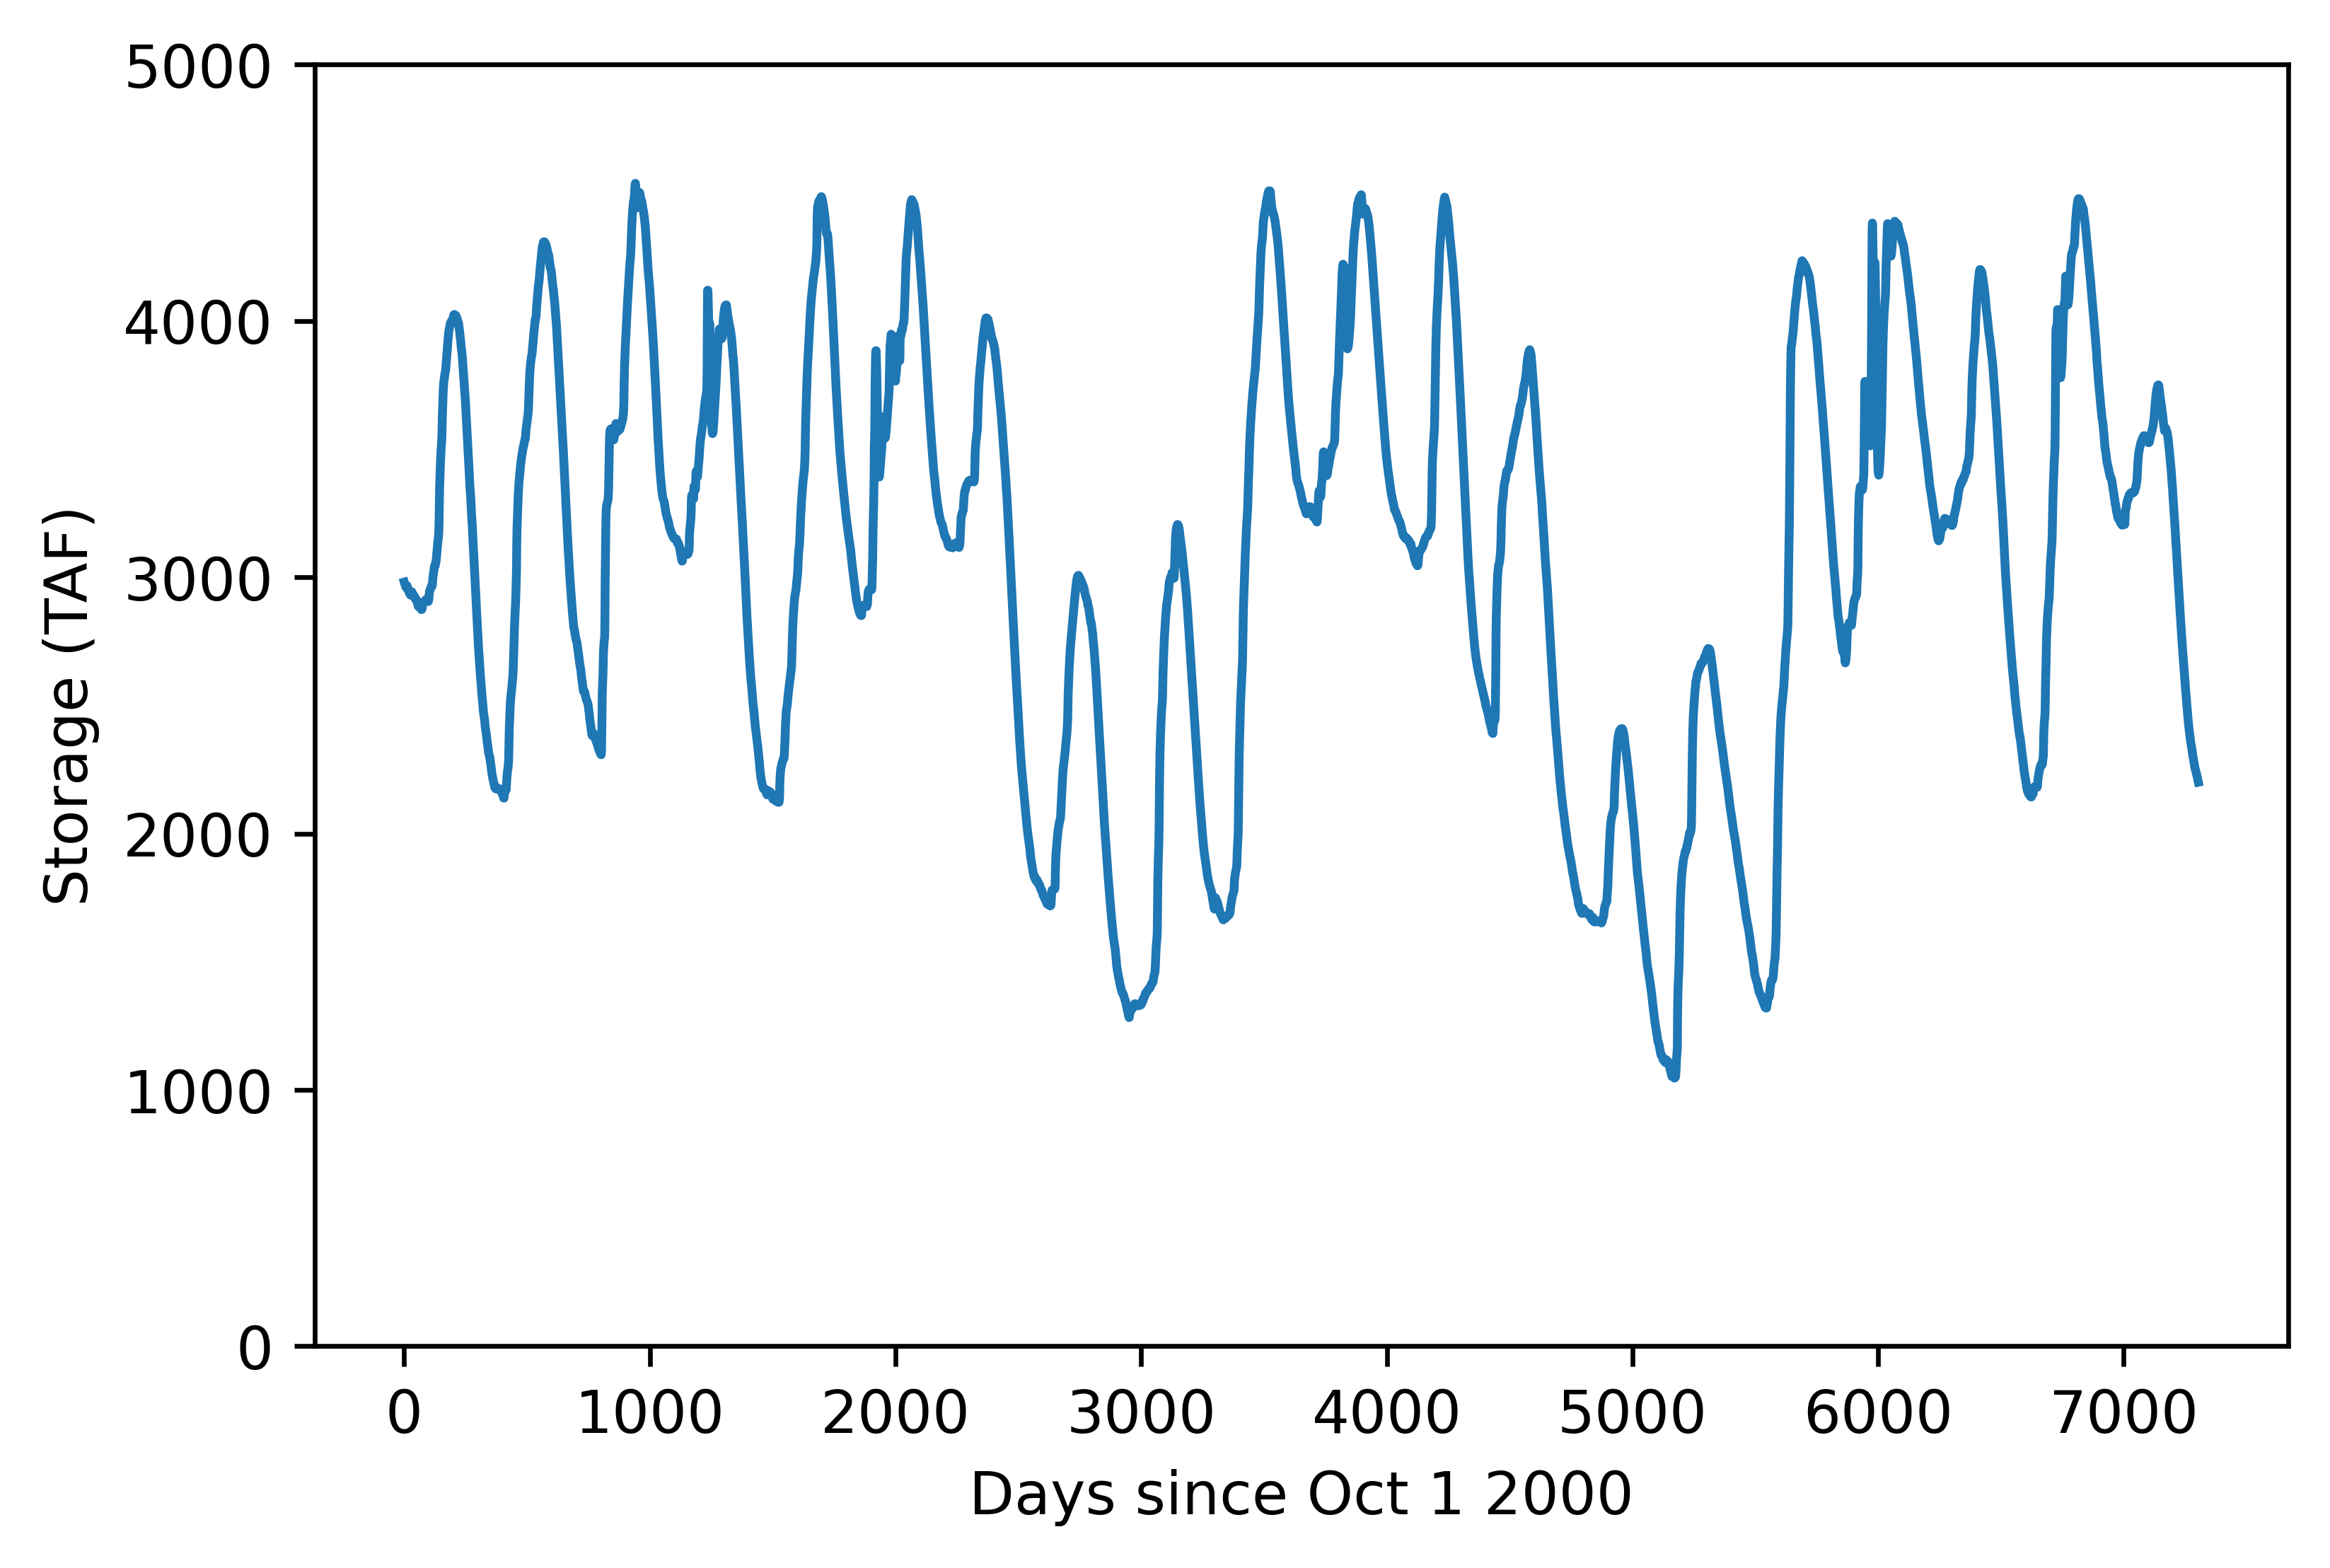

In [10]:
plt.plot(storage)
plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Storage (TAF)')
plt.ylim([0,5000])
plt.show()

#### Second plot: time series of inflow and outflow

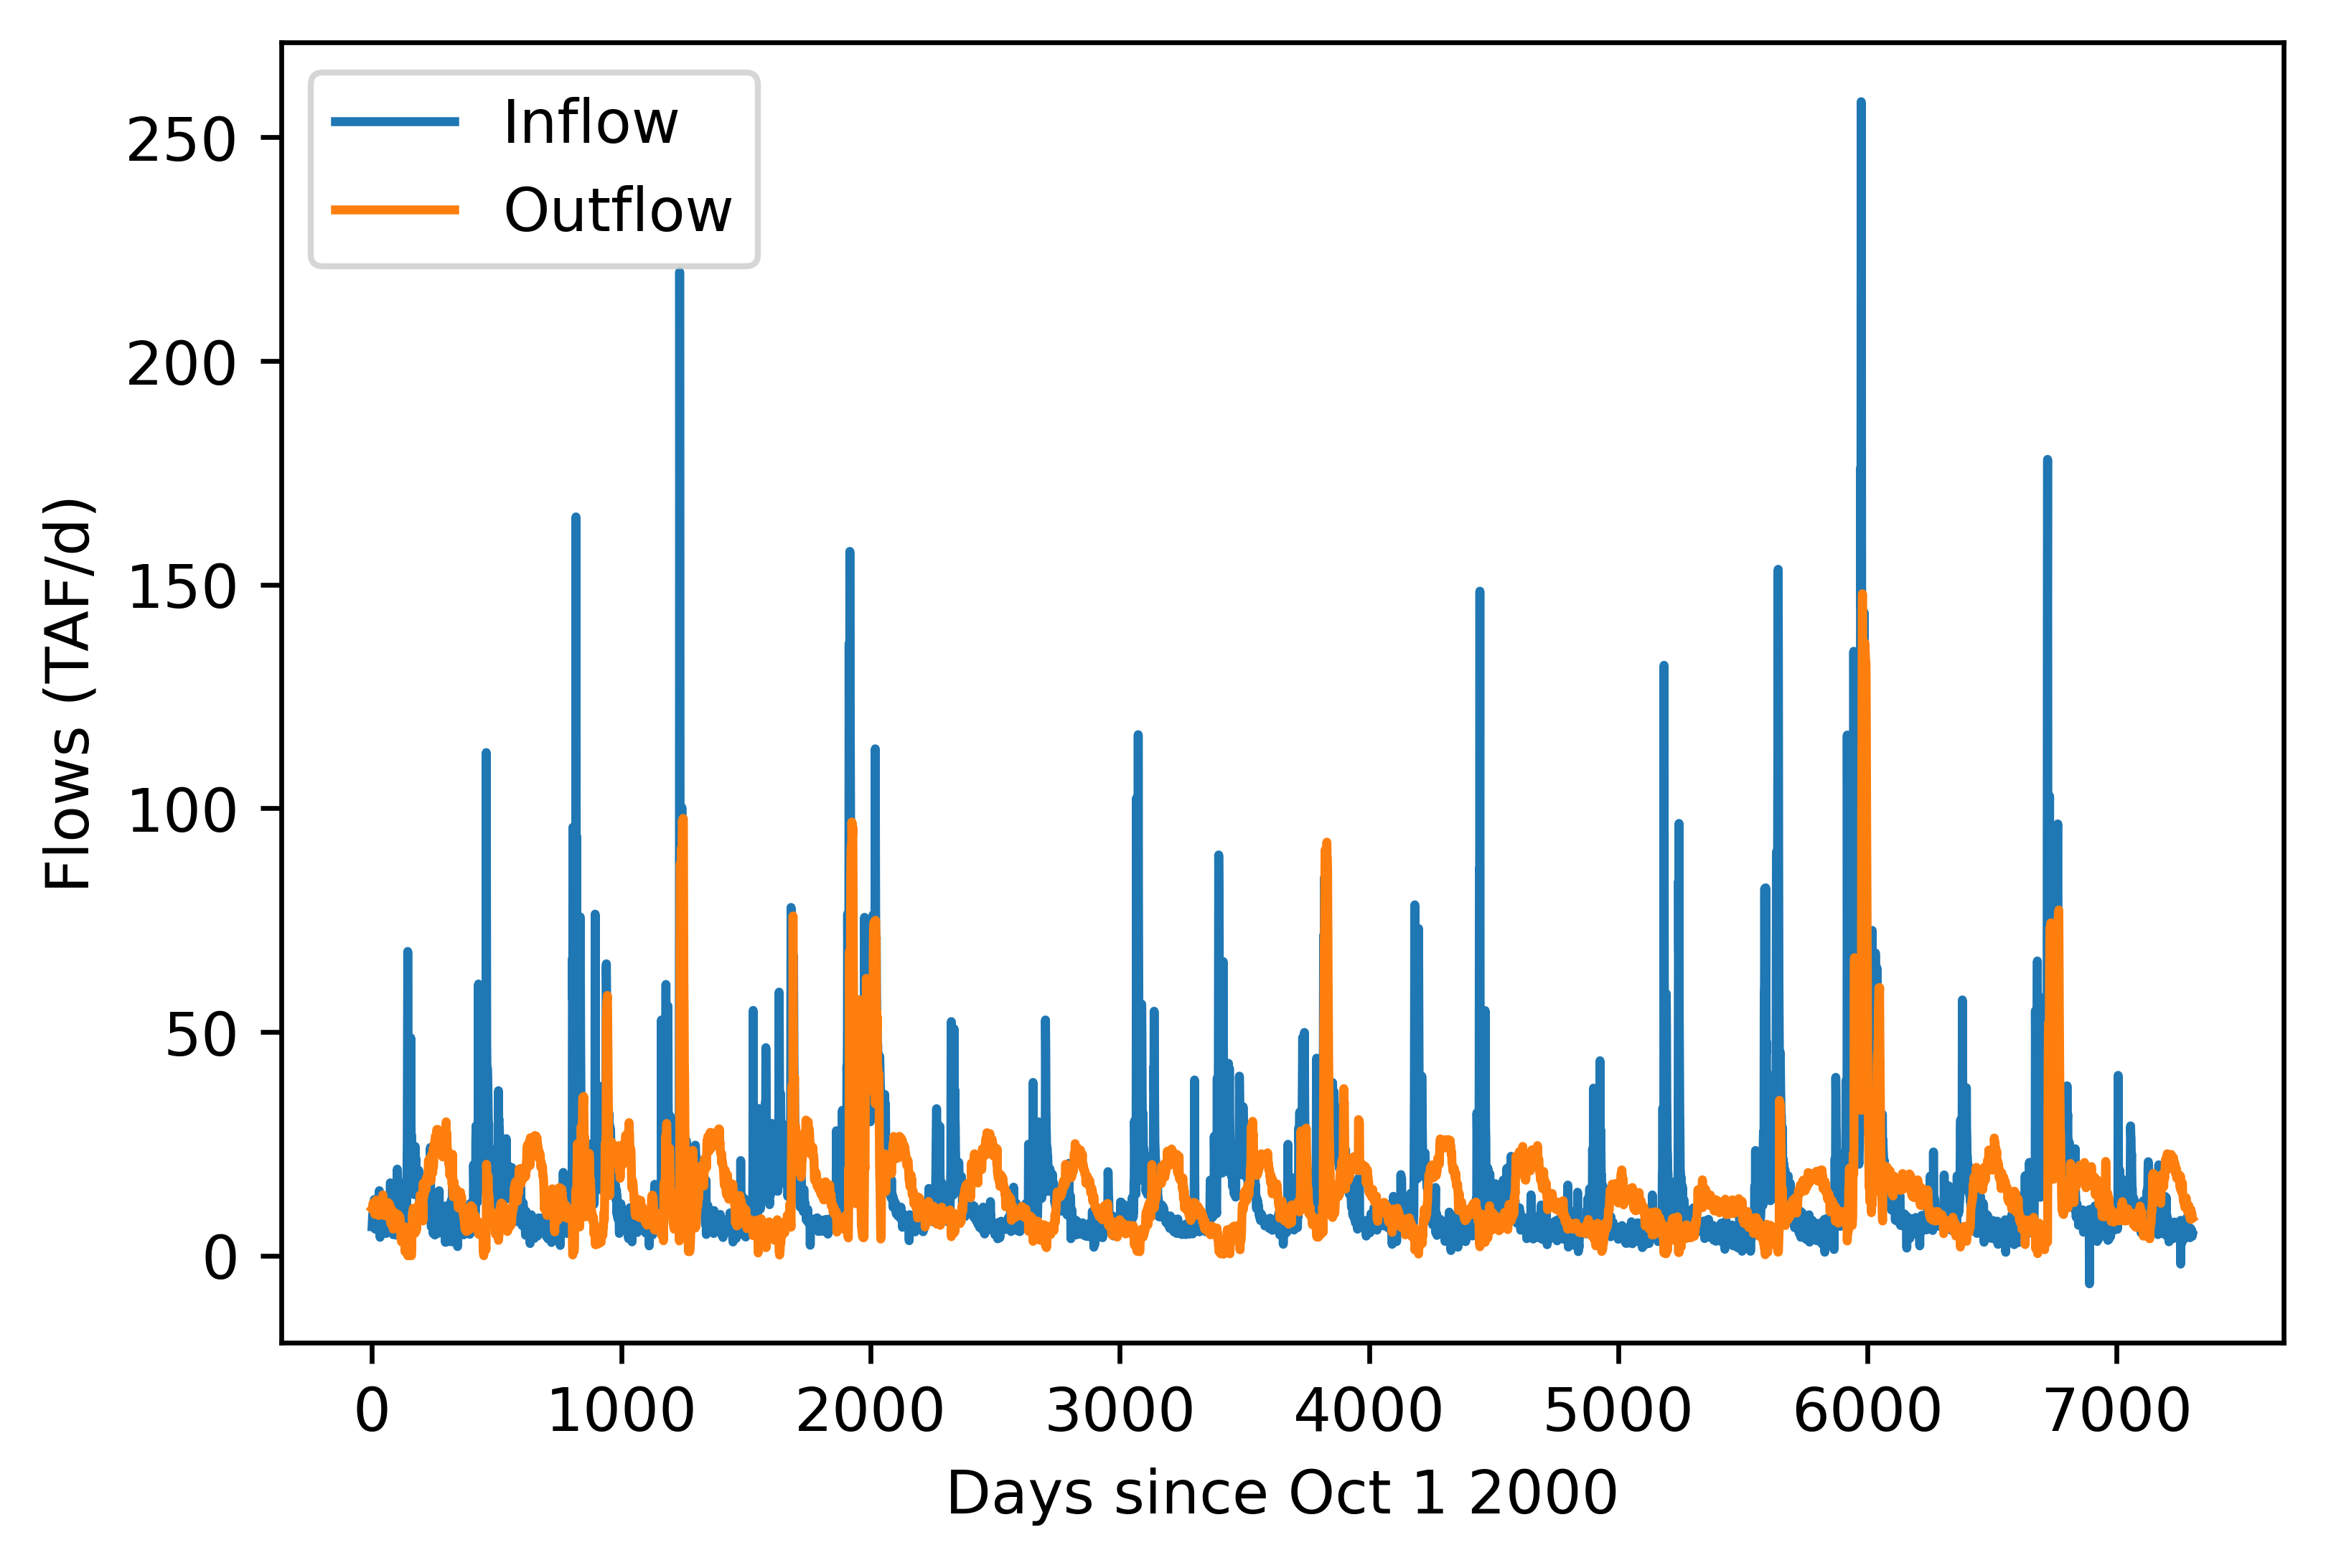

In [11]:
plt.plot(inflow)
plt.plot(outflow)
plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Flows (TAF/d)')
plt.legend(['Inflow', 'Outflow'])
plt.show()

#### Third plot: exceedance plot of inflow and outflow

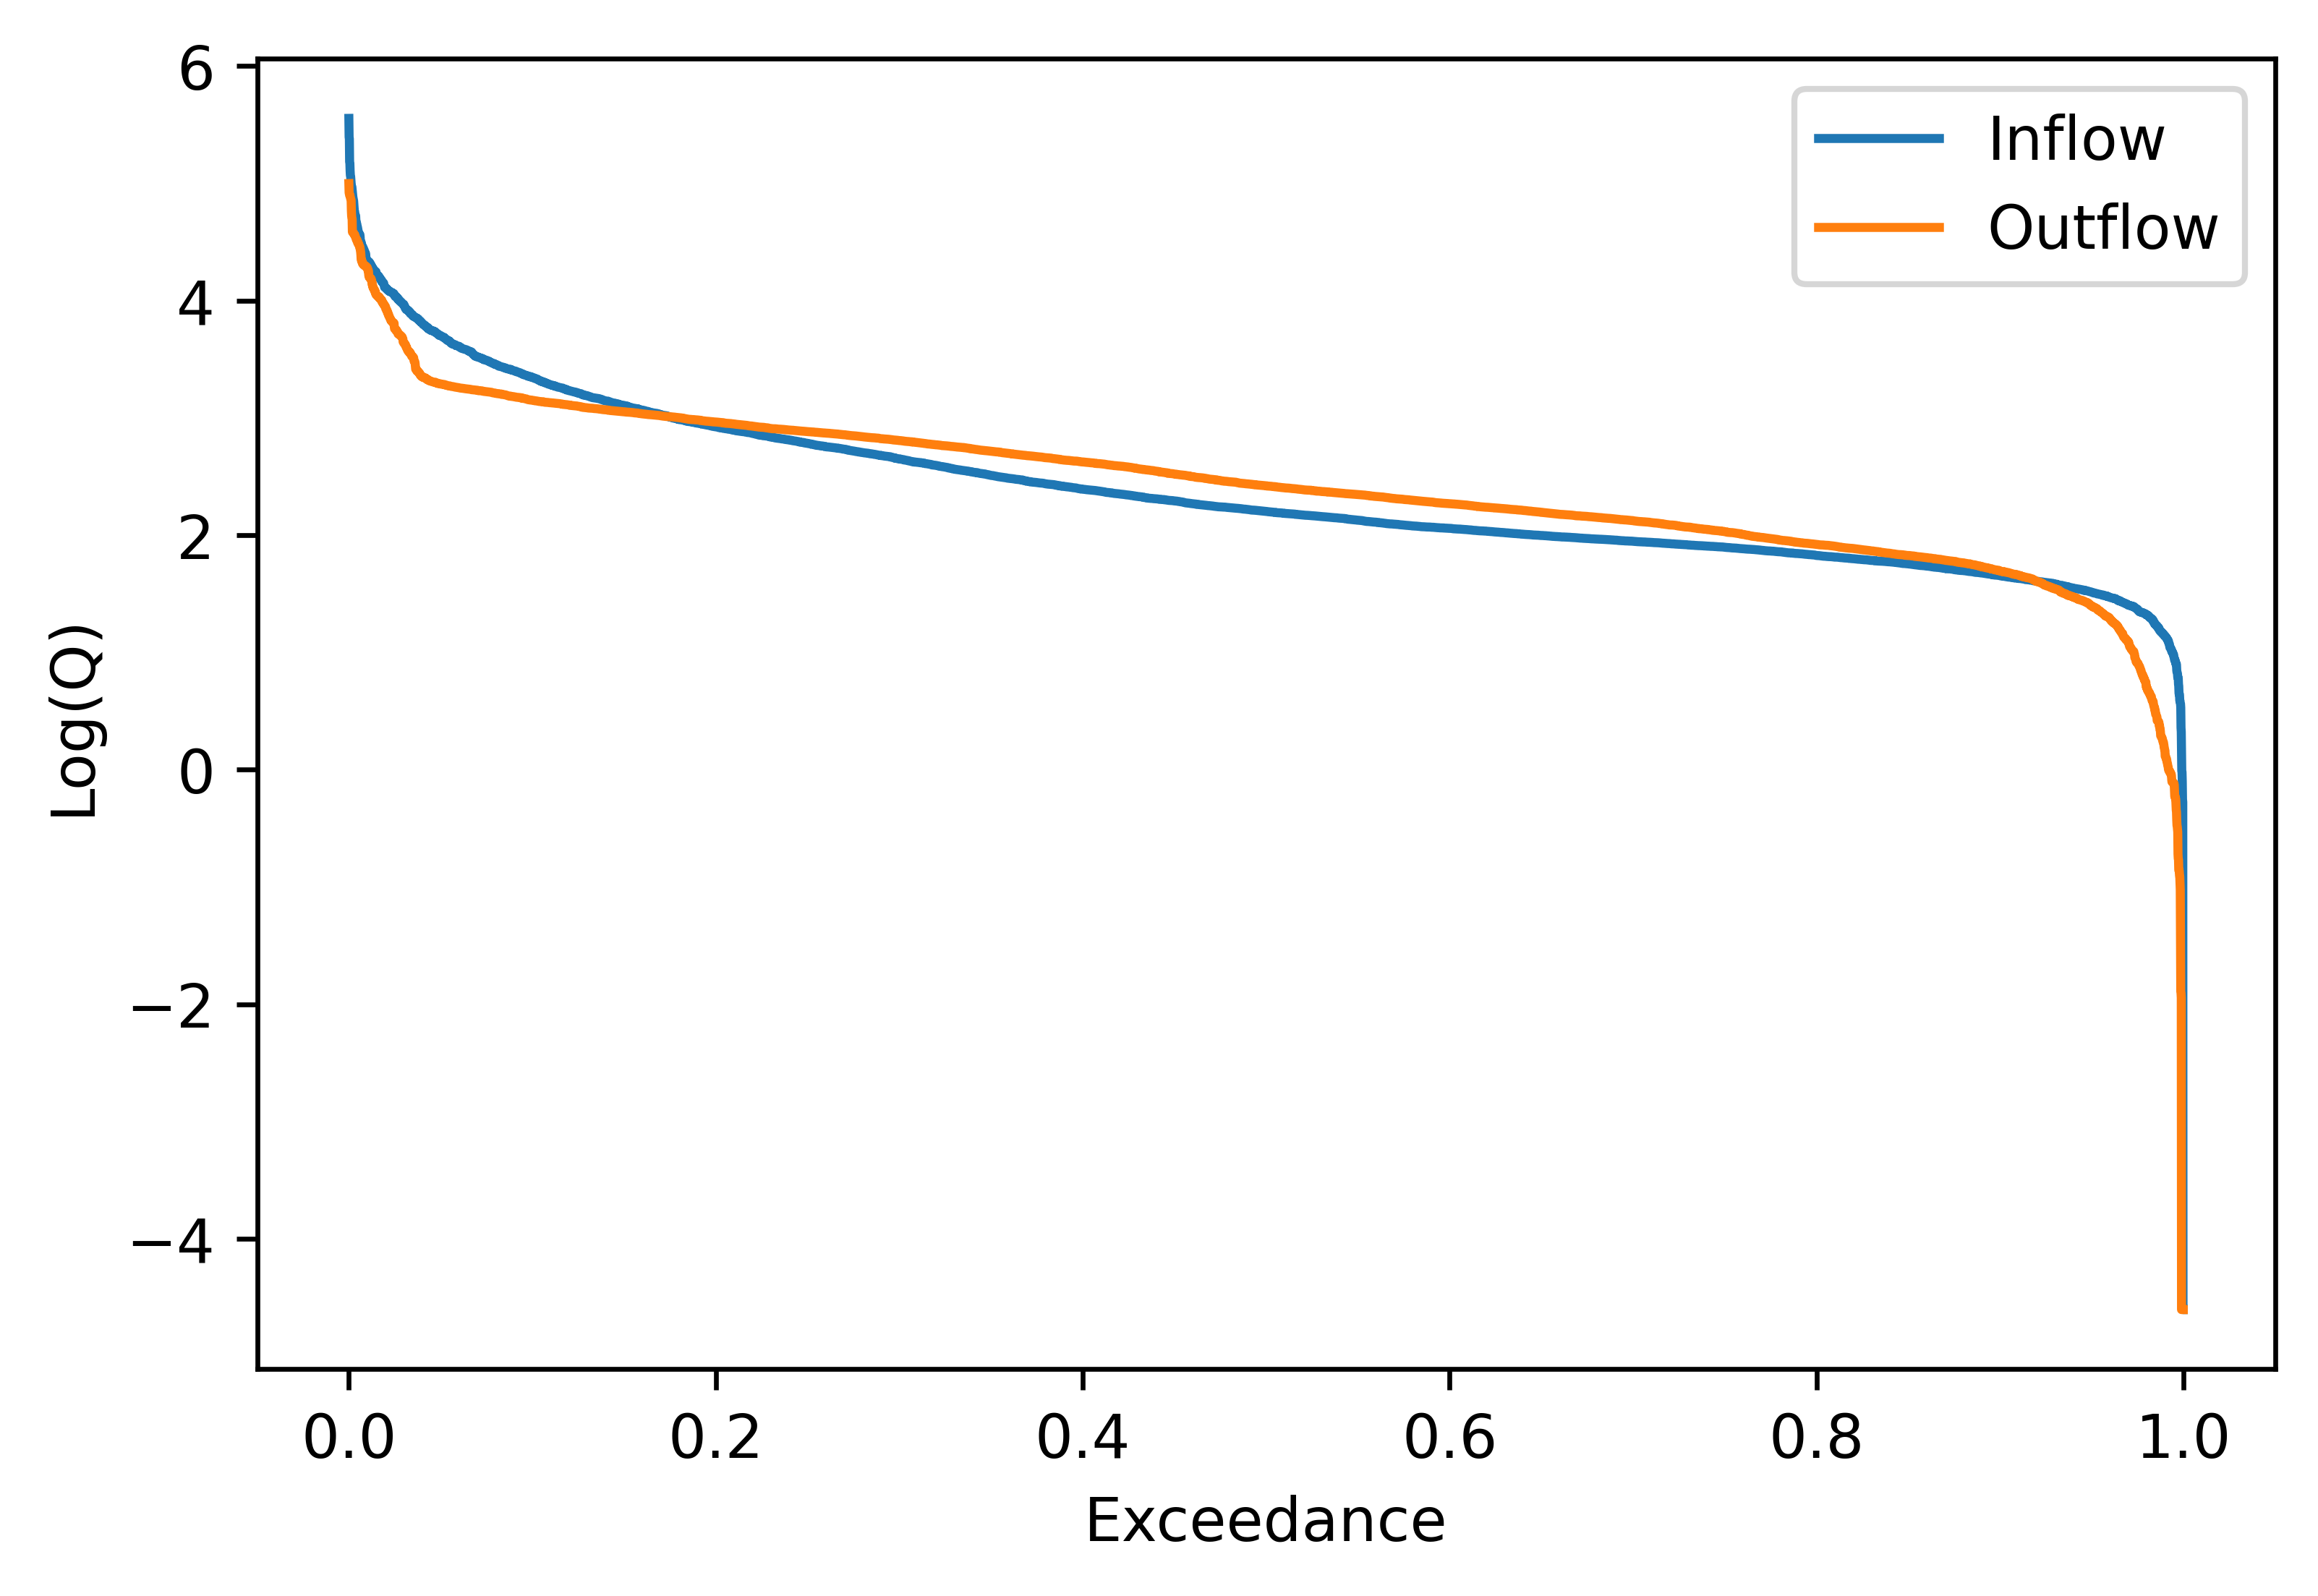

In [12]:
T = len(inflow)

# before log-transforming, replace ~zeros with small values to avoid warning
inflow[inflow < 0.01] = 0.01
outflow[outflow < 0.01] = 0.01
log_inflow = np.log(inflow)
log_outflow = np.log(outflow)

plt.plot(np.arange(T)/T, np.sort(log_inflow)[::-1])
plt.plot(np.arange(T)/T, np.sort(log_outflow)[::-1])
plt.legend(['Inflow', 'Outflow'])
plt.ylabel('Log(Q)')
plt.xlabel('Exceedance')
plt.show()

#### Fourth plot: historical storage for Folsom, Oroville, and Shasta

Plot on the same graph

In [13]:
reservoirs = ['FOL', 'ORO', 'SHA']

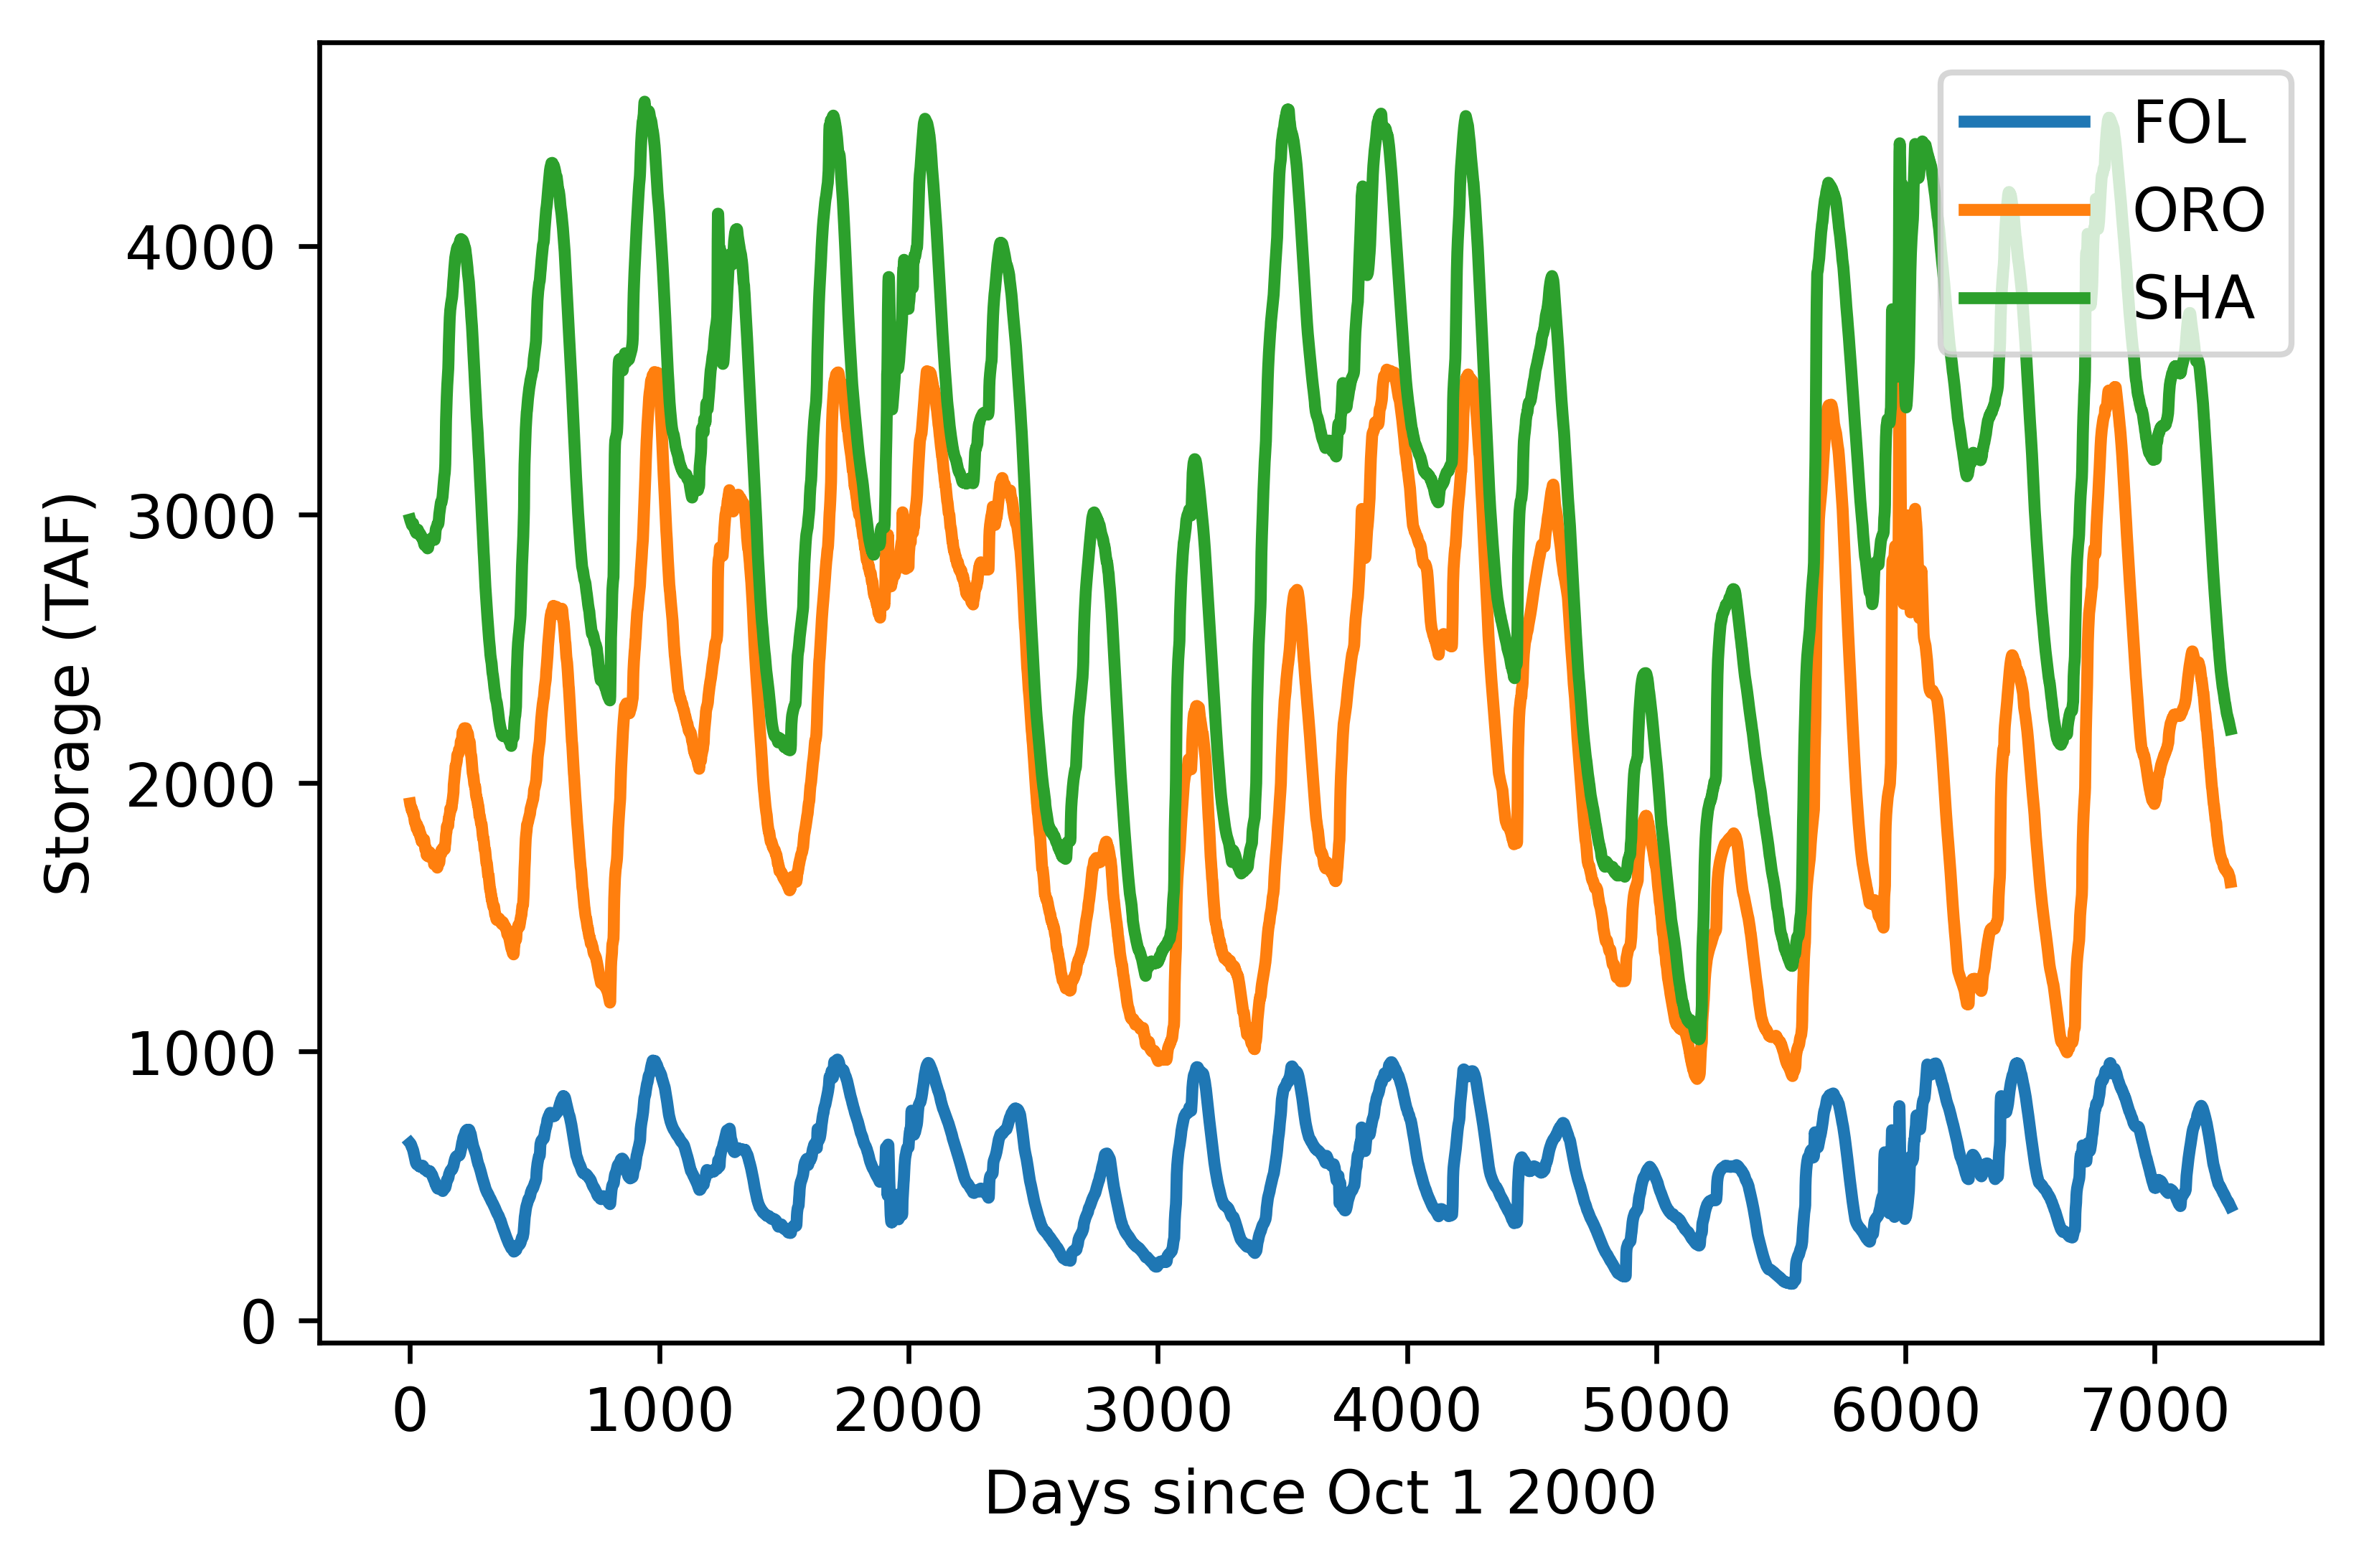

In [15]:
for r in reservoirs:
    data = np.loadtxt('../data/' + r + '.csv', 
                    delimiter=',', 
                    skiprows=1, 
                    usecols=[1,2,3])
    
    storage = data[:,2] / 1000 # AF to TAF
    plt.plot(storage, linewidth=2)

plt.xlabel('Days since Oct 1 2000')
plt.ylabel('Storage (TAF)')
plt.legend(reservoirs)

# optional - save to file
# plt.savefig('something.png') # or .pdf, .svg, etc.
plt.show()

-------------------

## Simulation model

Mass balance reservoir simulation with constant demand and standard operating policy.

In [27]:
K = 975 # capacity, TAF
D = 5 # target demand, TAF/day

Data setup:

In [28]:
Q = np.loadtxt('../data/FOL.csv', delimiter=',', 
                skiprows=1, usecols=[1])
Q *= cfs_to_tafd
T = len(Q)

S = np.zeros(T)
R = np.zeros(T)
shortage = np.zeros(T)

S[0] = K/2 # start simulation full
R[0] = D # first day meets demand
met_demand = 1 # counter

In [29]:
for t in range(1,T):

  # new storage: mass balance, max value is K
  S[t] = min(S[t-1] + Q[t-1] - R[t-1], K)

  # release is based on demand
  if S[t] + Q[t] > D:
    R[t] = D
    met_demand = met_demand + 1
  else:
    R[t] = S[t] + Q[t]

  shortage[t] = D-R[t]

reliability = met_demand / T
print('The reliability is', reliability)

The reliability is 0.9065023956194388


Plot storage, inflow, outflow, and shortage as subplots

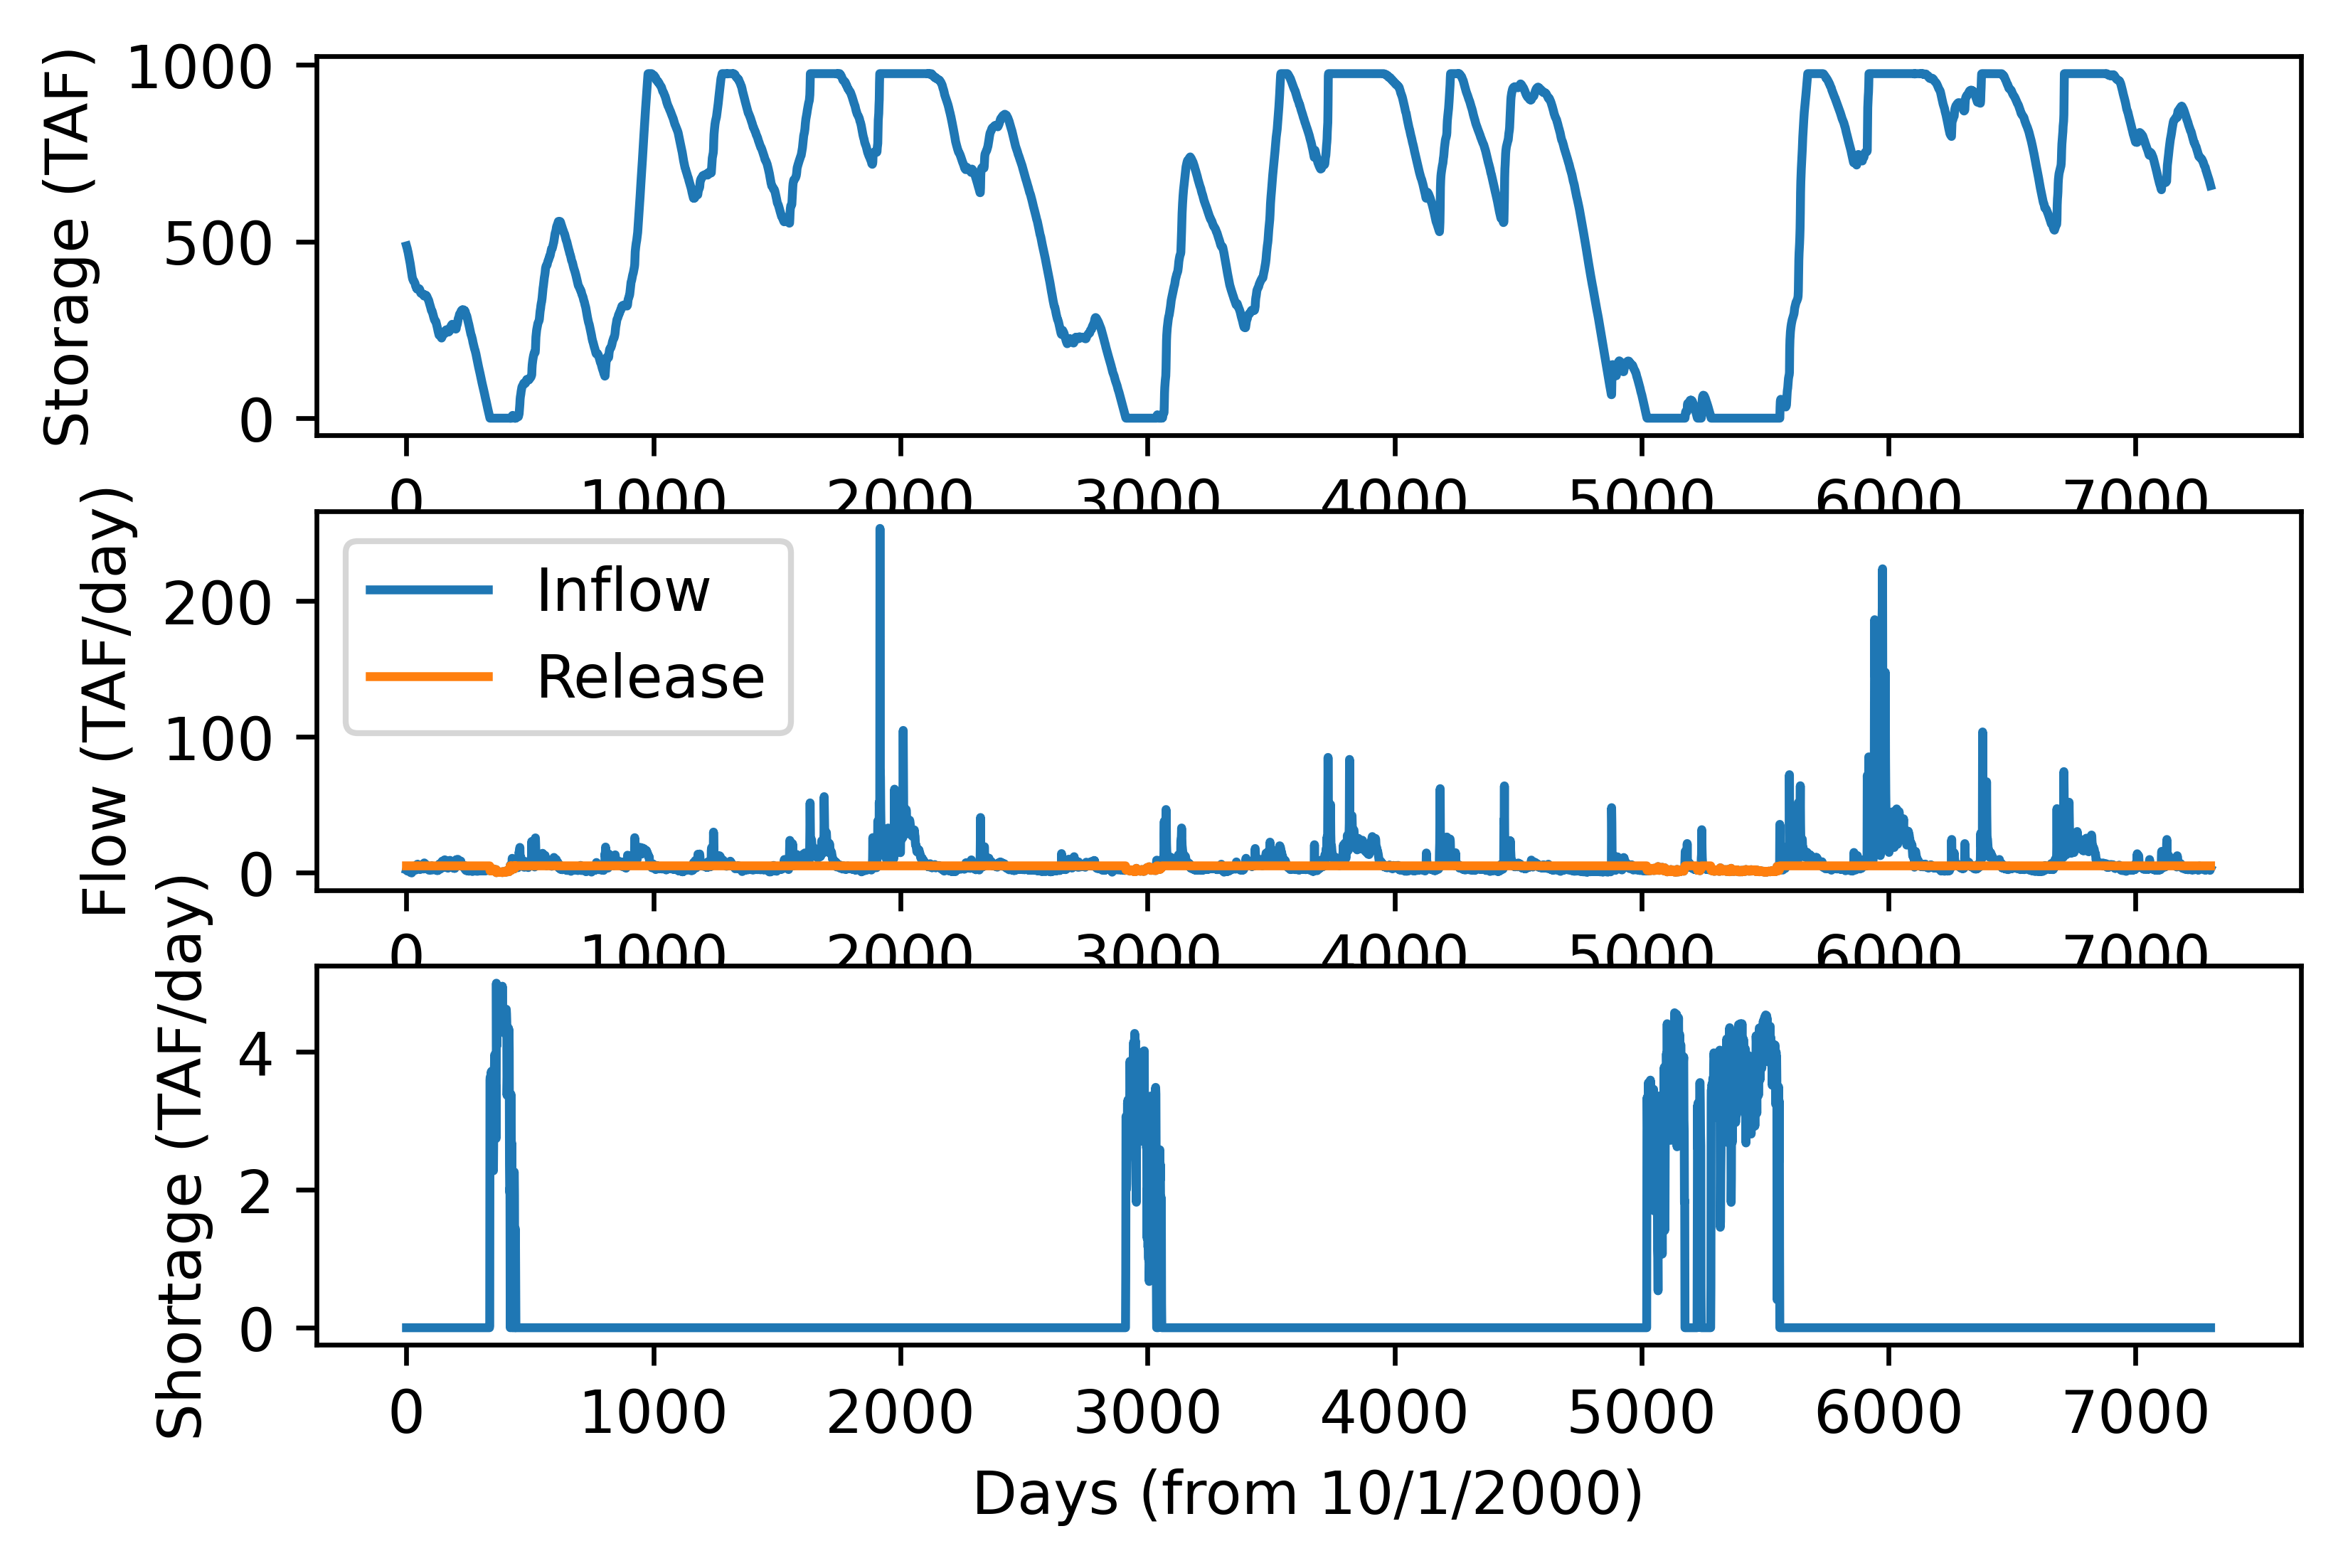

In [30]:
plt.subplot(3,1,1)
plt.plot(S)
plt.ylabel('Storage (TAF)')

plt.subplot(3,1,2)
plt.plot(Q)
plt.plot(R)
plt.legend(['Inflow', 'Release'])
plt.ylabel('Flow (TAF/day)')

plt.subplot(3,1,3)
plt.plot(shortage)
plt.ylabel('Shortage (TAF/day)')
plt.xlabel('Days (from 10/1/2000)')

plt.show()

------------

Extensions: using the `ulmo` package to download CDEC data

Installation instructions: https://github.com/ulmo-dev/ulmo

CDEC API: https://ulmo.readthedocs.io/en/latest/api.html#module-ulmo.cdec.historical


In [37]:
from ulmo import cdec

# find all sensors for a station
cdec.historical.get_station_sensors(['SHA'])

{'SHA':                variable  sensor_id resolution    varcode               method  \
 0             DISCHARGE         48      daily  (DIS PWR)       DATA XCHG-USBR   
 1             DISCHARGE         71      daily    (SPILL)       DATA XCHG-USBR   
 2             DISCHARGE         85      daily  (RIV REL)       DATA XCHG-USBR   
 3           EVAPORATION         74      daily     (EVAP)       DATA XCHG-USBR   
 4     FULL NATURAL FLOW          8      daily      (FNF)       DATA XCHG-USBR   
 5         PRECIPITATION          2      daily     (RAIN)             COMPUTED   
 6         PRECIPITATION         45      daily  (PPT INC)       DATA XCHG-USBR   
 7                   RES        200      daily  (ABV TOC)             COMPUTED   
 8   RESERVOIR ELEVATION          6      daily  (RES ELE)       DATA XCHG-USBR   
 9      RESERVOIR INFLOW         76      daily   (INFLOW)       DATA XCHG-USBR   
 10    RESERVOIR OUTFLOW         23      daily  (OUTFLOW)       DATA XCHG-USBR   
 11    RE

In [53]:
# download - returns a dictionary of pandas DataFrame objects
data = cdec.historical.get_data(['SHA'], resolutions=['daily'], start='10-01-2000', end='09-30-2021')

In [54]:
print(data)

{'SHA': {'DISCHARGE': Empty DataFrame
Columns: [station_id, duration, sensor_number, sensor_type, obs_date, value, data_flag, units]
Index: [], 'EVAPORATION': Empty DataFrame
Columns: [station_id, duration, sensor_number, sensor_type, obs_date, value, data_flag, units]
Index: [], 'FULL NATURAL FLOW': Empty DataFrame
Columns: [station_id, duration, sensor_number, sensor_type, obs_date, value, data_flag, units]
Index: [], 'PRECIPITATION': Empty DataFrame
Columns: [station_id, duration, sensor_number, sensor_type, obs_date, value, data_flag, units]
Index: [], 'RES': Empty DataFrame
Columns: [station_id, duration, sensor_number, sensor_type, obs_date, value, data_flag, units]
Index: [], 'RESERVOIR ELEVATION': Empty DataFrame
Columns: [station_id, duration, sensor_number, sensor_type, obs_date, value, data_flag, units]
Index: [], 'RESERVOIR INFLOW': Empty DataFrame
Columns: [station_id, duration, sensor_number, sensor_type, obs_date, value, data_flag, units]
Index: [], 'RESERVOIR OUTFLOW': 